In [2]:
# phase1_generate.py
import pandas as pd
import numpy as np

# CONFIG
N_MERCHANTS = 100_000
FRAUD_RATE = 0.11
SEED = 42
rng = np.random.default_rng(SEED)

print("PHASE 1 — create merchant ids + labels")
df = pd.DataFrame({"merchant_id": [f"M_{i}" for i in range(N_MERCHANTS)]})

n_fraud = int(N_MERCHANTS * FRAUD_RATE)
labels = np.zeros(N_MERCHANTS, dtype=int)
labels[:n_fraud] = 1
rng.shuffle(labels)
df["is_fraud"] = labels

OUT = "merchant_synthetic_100k_phase1.csv"
df.to_csv(OUT, index=False)
print("Saved:", OUT)


PHASE 1 — create merchant ids + labels
Saved: merchant_synthetic_100k_phase1.csv


In [3]:
# phase2_generate.py
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

SEED = 42
rng = np.random.default_rng(SEED)

print("PHASE 2 — add profile + hashed ids")

IN = "merchant_synthetic_100k_phase1.csv"
OUT = "merchant_synthetic_100k_phase2.csv"

df = pd.read_csv(IN)
N = len(df)

# ============================================================
# BASIC PROFILE (with realistic variations)
# ============================================================

base_date = datetime(2024, 1, 1)
df["merchant_registration_date"] = [
    (base_date - timedelta(days=int(rng.integers(0, 1500)))).isoformat()
    for _ in range(N)
]

categories = ["kirana", "delivery", "marketplace", "digital_goods", "services", "restaurant"]
tiers = ["micro", "small", "medium", "enterprise"]
cities = [f"City_{i}" for i in range(1, 201)]

df["merchant_category"] = rng.choice(categories, size=N, p=[0.35,0.25,0.1,0.08,0.12,0.1])
df["business_city"] = rng.choice(cities, size=N)
df["merchant_tier"] = rng.choice(tiers, size=N, p=[0.55,0.25,0.15,0.05])

# ============================================================
# KYC VERIFICATION (more realistic)
# ============================================================

# Fraud merchants less likely to be KYC verified, but not always
fraud_mask = df["is_fraud"] == 1
clean_mask = ~fraud_mask

# 60% of fraud are NOT KYC verified, but 40% ARE (sophisticated fraud)
df.loc[fraud_mask, "is_kyc_verified"] = rng.choice([0, 1], size=fraud_mask.sum(), p=[0.60, 0.40])

# 85% of clean are KYC verified, 15% are not (lazy or new merchants)
df.loc[clean_mask, "is_kyc_verified"] = rng.choice([0, 1], size=clean_mask.sum(), p=[0.15, 0.85])

# ============================================================
# HASHED IDENTIFIERS (assigned in phase5 for better control)
# ============================================================
# Create placeholder columns - actual assignment happens in phase5
PAN_clean_pool = [f"PAN_C_{i}" for i in range(180_000)]
DEV_clean_pool = [f"DEV_C_{i}" for i in range(140_000)]
IP_clean_pool = [f"IP_C_{i}" for i in range(140_000)]

# Temporary random assignment (will be overwritten in phase5)
df["pan_hash"] = [PAN_clean_pool[i] for i in rng.integers(0, len(PAN_clean_pool), N)]
df["device_id_hash"] = [DEV_clean_pool[i] for i in rng.integers(0, len(DEV_clean_pool), N)]
df["ip_hash"] = [IP_clean_pool[i] for i in rng.integers(0, len(IP_clean_pool), N)]

df.to_csv(OUT, index=False)
print("Saved:", OUT)


PHASE 2 — add profile + hashed ids
Saved: merchant_synthetic_100k_phase2.csv
Saved: merchant_synthetic_100k_phase2.csv


In [4]:
# phase3_generate.py
import pandas as pd
import numpy as np

SEED = 42
rng = np.random.default_rng(SEED)

IN = "merchant_synthetic_100k_phase2.csv"
OUT = "merchant_synthetic_100k_phase3.csv"

print("PHASE 3 — transactional aggregates")

df = pd.read_csv(IN)
N = len(df)

# base distributions
df["total_txns_90d"] = rng.lognormal(mean=2.4, sigma=1.1, size=N).astype(int)
df["avg_txn_value"] = np.clip(rng.normal(950, 350, N), 10, 200_000).round(2)
df["chargeback_rate"] = np.round(rng.beta(1.6, 40, N), 4)
df["refund_ratio"] = np.round(rng.beta(1.3, 25, N), 4)
df["merchant_age_days"] = rng.integers(20, 1200, N)

# Get fraud and clean indices
fraud_mask = df["is_fraud"] == 1
fraud_idx = df.index[fraud_mask].to_numpy()
clean_idx = df.index[~fraud_mask].to_numpy()

# ============================================================
# REALISTIC FRAUD: Create 3 types of fraud merchants
# ============================================================

# Type 1: Obvious fraud (40% of fraud) - clear signals
n_obvious = int(len(fraud_idx) * 0.40)
obvious_idx = rng.choice(fraud_idx, size=n_obvious, replace=False)
df.loc[obvious_idx, "avg_txn_value"] *= rng.uniform(1.6, 2.5, size=n_obvious)
df.loc[obvious_idx, "chargeback_rate"] += rng.uniform(0.15, 0.35, size=n_obvious)
df.loc[obvious_idx, "refund_ratio"] += rng.uniform(0.12, 0.28, size=n_obvious)

# Type 2: Moderate fraud (35% of fraud) - mixed signals
remaining_fraud = np.setdiff1d(fraud_idx, obvious_idx)
n_moderate = int(len(fraud_idx) * 0.35)
moderate_idx = rng.choice(remaining_fraud, size=n_moderate, replace=False)
df.loc[moderate_idx, "avg_txn_value"] *= rng.uniform(1.2, 1.6, size=n_moderate)
df.loc[moderate_idx, "chargeback_rate"] += rng.uniform(0.05, 0.15, size=n_moderate)
df.loc[moderate_idx, "refund_ratio"] += rng.uniform(0.03, 0.12, size=n_moderate)

# Type 3: Hard-to-detect fraud (25% of fraud) - very weak signals, looks almost legitimate
hard_fraud_idx = np.setdiff1d(remaining_fraud, moderate_idx)
df.loc[hard_fraud_idx, "avg_txn_value"] *= rng.uniform(0.95, 1.25, size=len(hard_fraud_idx))
df.loc[hard_fraud_idx, "chargeback_rate"] += rng.uniform(0.01, 0.06, size=len(hard_fraud_idx))
df.loc[hard_fraud_idx, "refund_ratio"] += rng.uniform(0.01, 0.05, size=len(hard_fraud_idx))

# ============================================================
# FALSE POSITIVES: Make some legitimate merchants look suspicious
# ============================================================
n_false_positive = int(len(clean_idx) * 0.08)  # 8% of clean merchants
false_pos_idx = rng.choice(clean_idx, size=n_false_positive, replace=False)

# These legitimate merchants have high chargebacks/refunds (customer service issues, returns, etc.)
df.loc[false_pos_idx, "chargeback_rate"] += rng.uniform(0.08, 0.20, size=n_false_positive)
df.loc[false_pos_idx, "refund_ratio"] += rng.uniform(0.06, 0.18, size=n_false_positive)
df.loc[false_pos_idx, "avg_txn_value"] *= rng.uniform(1.3, 1.9, size=n_false_positive)

# ============================================================
# ADD RANDOM NOISE to all merchants (data quality issues)
# ============================================================
noise_mask = rng.random(N) < 0.15  # 15% get additional noise
df.loc[noise_mask, "chargeback_rate"] += rng.uniform(-0.02, 0.05, noise_mask.sum())
df.loc[noise_mask, "refund_ratio"] += rng.uniform(-0.02, 0.04, noise_mask.sum())
df.loc[noise_mask, "avg_txn_value"] *= rng.uniform(0.85, 1.15, noise_mask.sum())

# clamp to valid ranges
df["chargeback_rate"] = df["chargeback_rate"].clip(0, 1)
df["refund_ratio"] = df["refund_ratio"].clip(0, 1)
df["avg_txn_value"] = df["avg_txn_value"].clip(10, 200_000)

df.to_csv(OUT, index=False)
print("Saved:", OUT)


PHASE 3 — transactional aggregates
Saved: merchant_synthetic_100k_phase3.csv
Saved: merchant_synthetic_100k_phase3.csv


In [5]:
# phase4_generate.py
import pandas as pd
import numpy as np

IN = "merchant_synthetic_100k_phase3.csv"
OUT = "merchant_synthetic_100k_phase4.csv"
rng = np.random.default_rng(42)

print("PHASE 4 — 30d/7d & high-value aggregates")

df = pd.read_csv(IN)
N = len(df)

# ============================================================
# MORE REALISTIC TEMPORAL VARIATIONS
# ============================================================

# Add variance - some merchants have spiky activity, others steady
activity_pattern = rng.choice(['steady', 'spiky', 'declining'], size=N, p=[0.5, 0.3, 0.2])

steady_mask = activity_pattern == 'steady'
spiky_mask = activity_pattern == 'spiky'
declining_mask = activity_pattern == 'declining'

# Steady pattern: consistent ratios
df.loc[steady_mask, "total_txns_30d"] = np.maximum(0, (
    df.loc[steady_mask, "total_txns_90d"] * rng.uniform(0.28, 0.38, steady_mask.sum())
).astype(int))

# Spiky pattern: recent activity burst (suspicious but not always fraud)
df.loc[spiky_mask, "total_txns_30d"] = np.maximum(0, (
    df.loc[spiky_mask, "total_txns_90d"] * rng.uniform(0.45, 0.75, spiky_mask.sum())
).astype(int))

# Declining pattern: less recent activity
df.loc[declining_mask, "total_txns_30d"] = np.maximum(0, (
    df.loc[declining_mask, "total_txns_90d"] * rng.uniform(0.10, 0.25, declining_mask.sum())
).astype(int))

# 7-day activity
df["total_txns_7d"] = np.maximum(0, (df["total_txns_30d"] * rng.uniform(0.1, 0.5, N)).astype(int))

# ============================================================
# TRANSACTION VALUE VARIATIONS (more realistic)
# ============================================================

# Recent values may differ from historical
df["avg_txn_value_30d"] = (df["avg_txn_value"] * rng.uniform(0.75, 1.35, N)).round(2)
df["median_txn_value_90d"] = (df["avg_txn_value"] * rng.uniform(0.4, 1.2, N)).round(2)

# Standard deviation varies widely (some merchants very consistent, others not)
consistency = rng.choice(['consistent', 'variable', 'erratic'], size=N, p=[0.4, 0.4, 0.2])
df.loc[consistency == 'consistent', "std_txn_value_90d"] = (
    df.loc[consistency == 'consistent', "avg_txn_value"] * rng.uniform(0.05, 0.25, (consistency == 'consistent').sum())
).round(2)
df.loc[consistency == 'variable', "std_txn_value_90d"] = (
    df.loc[consistency == 'variable', "avg_txn_value"] * rng.uniform(0.25, 0.65, (consistency == 'variable').sum())
).round(2)
df.loc[consistency == 'erratic', "std_txn_value_90d"] = (
    df.loc[consistency == 'erratic', "avg_txn_value"] * rng.uniform(0.65, 1.5, (consistency == 'erratic').sum())
).round(2)

# Min/Max with realistic ranges
df["min_txn_value_30d"] = (df["avg_txn_value"] * rng.uniform(0.01, 0.45, N)).round(2)
df["max_txn_value_30d"] = (df["avg_txn_value"] * rng.uniform(1.0, 8.0, N)).round(2)

# ============================================================
# HIGH-VALUE TRANSACTIONS (with noise)
# ============================================================

# Most merchants have few high-value txns, some have many
base_pct = rng.beta(0.8, 6, N)

# Add fraud bias (but not perfect)
fraud_mask = df["is_fraud"] == 1
# Only some fraud merchants have high % of high-value txns
fraud_high_value = rng.random(fraud_mask.sum()) < 0.6  # 60% of fraud
df.loc[fraud_mask, "pct_high_value_txns"] = np.where(
    fraud_high_value,
    base_pct[fraud_mask] * rng.uniform(1.5, 3.5, fraud_mask.sum()),
    base_pct[fraud_mask] * rng.uniform(0.8, 1.2, fraud_mask.sum())
)

# Some clean merchants also have high-value transactions (luxury goods, etc.)
clean_mask = ~fraud_mask
clean_high_value = rng.random(clean_mask.sum()) < 0.12  # 12% of clean
df.loc[clean_mask, "pct_high_value_txns"] = np.where(
    clean_high_value,
    base_pct[clean_mask] * rng.uniform(1.8, 4.0, clean_mask.sum()),
    base_pct[clean_mask]
)

df["pct_high_value_txns"] = np.round(df["pct_high_value_txns"].clip(0, 1), 4)

df["high_value_txns_90d"] = (df["total_txns_90d"] * df["pct_high_value_txns"]).astype(int)
df["high_value_txns_30d"] = (df["total_txns_30d"] * df["pct_high_value_txns"]).astype(int)

# ============================================================
# ADD SOME MISSING/INCONSISTENT DATA (data quality issues)
# ============================================================

# Some records have inconsistencies
inconsistent_mask = rng.random(N) < 0.08
df.loc[inconsistent_mask, "total_txns_7d"] = np.clip(
    df.loc[inconsistent_mask, "total_txns_7d"] + rng.integers(-5, 8, inconsistent_mask.sum()),
    0, df.loc[inconsistent_mask, "total_txns_30d"]
)

df.to_csv(OUT, index=False)
print("Saved:", OUT)


PHASE 4 — 30d/7d & high-value aggregates


C:\Users\rites\AppData\Local\Temp\ipykernel_14660\3559712567.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[inconsistent_mask, "total_txns_7d"] = np.clip(


Saved: merchant_synthetic_100k_phase4.csv


In [1]:
# phase5_generate.py
import pandas as pd
import numpy as np

IN = "merchant_synthetic_100k_phase4.csv"
OUT = "merchant_synthetic_100k_phase5.csv"
EDGE_OUT = "merchant_edges.csv"
rng = np.random.default_rng(42)

print("PHASE 5 — shared counts + edge list creation (edge list will be expanded in phase6)")

df = pd.read_csv(IN)
N = len(df)

# ============================================================
# CREATE REALISTIC FRAUD RINGS
# ============================================================

fraud_mask = df["is_fraud"] == 1
fraud_merchants = df[fraud_mask]["merchant_id"].values
clean_merchants = df[~fraud_mask]["merchant_id"].values

# Fraud pools (smaller, to create fraud rings)
PAN_fraud_pool = [f"PAN_F_{i}" for i in range(800)]   # Smaller pool = more sharing
DEV_fraud_pool = [f"DEV_F_{i}" for i in range(1200)]
IP_fraud_pool = [f"IP_F_{i}" for i in range(1500)]

# Clean pools (larger, less sharing)
PAN_clean_pool = [f"PAN_C_{i}" for i in range(180_000)]
DEV_clean_pool = [f"DEV_C_{i}" for i in range(140_000)]
IP_clean_pool = [f"IP_C_{i}" for i in range(140_000)]

# Assign fraud hashes (creating fraud rings)
# Only 70% of fraud merchants are in tight rings
n_connected_fraud = int(len(fraud_merchants) * 0.70)
connected_fraud_idx = rng.choice(len(fraud_merchants), size=n_connected_fraud, replace=False)
connected_fraud_mask = np.zeros(len(fraud_merchants), dtype=bool)
connected_fraud_mask[connected_fraud_idx] = True

# Create hash assignments arrays
pan_hashes = np.empty(N, dtype=object)
device_hashes = np.empty(N, dtype=object)
ip_hashes = np.empty(N, dtype=object)

# Connected fraud: high sharing (fraud rings) - VECTORIZED
fraud_indices = np.where(fraud_mask)[0]
connected_indices = fraud_indices[connected_fraud_mask]
isolated_indices = fraud_indices[~connected_fraud_mask]

pan_hashes[connected_indices] = rng.choice(PAN_fraud_pool, size=len(connected_indices))
device_hashes[connected_indices] = rng.choice(DEV_fraud_pool, size=len(connected_indices))
ip_hashes[connected_indices] = rng.choice(IP_fraud_pool, size=len(connected_indices))

# Isolated fraud: looks like clean (no obvious connections) - VECTORIZED
pan_hashes[isolated_indices] = rng.choice(PAN_clean_pool, size=len(isolated_indices))
device_hashes[isolated_indices] = rng.choice(DEV_clean_pool, size=len(isolated_indices))
ip_hashes[isolated_indices] = rng.choice(IP_clean_pool, size=len(isolated_indices))

# Assign clean merchant hashes - VECTORIZED
clean_indices = np.where(~fraud_mask)[0]
pan_hashes[clean_indices] = rng.choice(PAN_clean_pool, size=len(clean_indices))
device_hashes[clean_indices] = rng.choice(DEV_clean_pool, size=len(clean_indices))
ip_hashes[clean_indices] = rng.choice(IP_clean_pool, size=len(clean_indices))

# ============================================================
# CREATE FALSE POSITIVE RINGS (legitimate merchants sharing IDs)
# ============================================================
n_false_pos_ring = int(len(clean_indices) * 0.05)  # 5% in false positive rings
false_pos_idx = rng.choice(clean_indices, size=n_false_pos_ring, replace=False)

# Create small shared pools for these
shared_pan_fp = [f"PAN_FP_{i}" for i in range(50)]
shared_dev_fp = [f"DEV_FP_{i}" for i in range(80)]

pan_hashes[false_pos_idx] = rng.choice(shared_pan_fp, size=n_false_pos_ring)
device_hashes[false_pos_idx] = rng.choice(shared_dev_fp, size=n_false_pos_ring)

# Assign to dataframe
df["pan_hash"] = pan_hashes
df["device_id_hash"] = device_hashes
df["ip_hash"] = ip_hashes

# ============================================================
# SHARED COUNTS
# ============================================================

def shared_count(series):
    vc = series.value_counts()
    return series.map(vc).fillna(0).astype(int) - 1

df["shared_pan_count"] = shared_count(df["pan_hash"])
df["shared_device_count"] = shared_count(df["device_id_hash"])
df["shared_ip_count"] = shared_count(df["ip_hash"])

# ============================================================
# PHONE/EMAIL/POS with realistic sharing - VECTORIZED
# ============================================================

phone_pool = [f"PH_{i}" for i in range(200_000)]
email_pool = [f"EM_{i}" for i in range(200_000)]
pos_pool = [f"POS_{i}" for i in range(60_000)]

# Initialize arrays
phone_hashes = np.empty(N, dtype=object)
email_hashes = np.empty(N, dtype=object)
pos_hashes = np.empty(N, dtype=object)

# Connected fraud: 40% share phone
share_phone_mask = rng.random(len(connected_indices)) < 0.4
shared_phone_idx = connected_indices[share_phone_mask]
normal_phone_idx = connected_indices[~share_phone_mask]

phone_hashes[shared_phone_idx] = [f"PH_fraud_{rng.integers(0, 100)}" for _ in range(len(shared_phone_idx))]
phone_hashes[normal_phone_idx] = rng.choice(phone_pool, size=len(normal_phone_idx))
email_hashes[connected_indices] = rng.choice(email_pool, size=len(connected_indices))
pos_hashes[connected_indices] = rng.choice(pos_pool, size=len(connected_indices))

# Clean and isolated fraud get normal assignments - VECTORIZED
other_indices = np.concatenate([clean_indices, isolated_indices])
phone_hashes[other_indices] = rng.choice(phone_pool, size=len(other_indices))
email_hashes[other_indices] = rng.choice(email_pool, size=len(other_indices))
pos_hashes[other_indices] = rng.choice(pos_pool, size=len(other_indices))

df["phone_hash"] = phone_hashes
df["email_hash"] = email_hashes
df["pos_terminal_id_hash"] = pos_hashes

df["shared_phone_count"] = shared_count(df["phone_hash"])
df["shared_email_count"] = shared_count(df["email_hash"])
df["shared_pos_terminal_count"] = shared_count(df["pos_terminal_id_hash"])


# ============================================================
# BUILD EDGE LIST (Create ONE large fraud ring + smaller ones)
# ============================================================

edge_list = []
rng = np.random.default_rng(42)

fraud_mask = df["is_fraud"] == 1
fraud_indices = np.where(fraud_mask)[0]
n_fraud = len(fraud_indices)

# Shuffle indices to randomize which fraud merchants go into which rings
rng.shuffle(fraud_indices)

# CREATE ONE LARGE FRAUD RING (40-60 merchants)
large_ring_size = rng.integers(40, 61)  # Random size between 40-60

print(f"Creating 1 large fraud ring with {large_ring_size} merchants...")

# Get the ACTUAL merchant IDs for the large ring (not indices)
large_ring_indices = fraud_indices[:large_ring_size]
large_ring_merchants = df.iloc[large_ring_indices]["merchant_id"].values

# Create circular connections for large ring
for i in range(len(large_ring_merchants)):
    merchant_a = large_ring_merchants[i]
    merchant_b = large_ring_merchants[(i + 1) % len(large_ring_merchants)]
    
    edge_type = rng.choice(['PAN', 'DEVICE', 'IP'], p=[0.5, 0.3, 0.2])
    weight_map = {'PAN': 3, 'DEVICE': 2, 'IP': 1}
    
    edge_list.append((merchant_a, merchant_b, weight_map[edge_type], edge_type))

# ADD CROSS-CONNECTIONS within large ring
for i in range(0, len(large_ring_merchants), 3):
    j = (i + 2) % len(large_ring_merchants)
    merchant_a = large_ring_merchants[i]
    merchant_b = large_ring_merchants[j]
    
    edge_type = rng.choice(['PAN', 'DEVICE', 'IP'], p=[0.4, 0.4, 0.2])
    weight_map = {'PAN': 3, 'DEVICE': 2, 'IP': 1}
    
    edge_list.append((merchant_a, merchant_b, weight_map[edge_type], edge_type))

# CREATE SMALLER FRAUD RINGS from remaining merchants
remaining_fraud_indices = fraud_indices[large_ring_size:]
remaining_pos = 0

while remaining_pos < len(remaining_fraud_indices):
    small_ring_size = min(rng.integers(5, 16), len(remaining_fraud_indices) - remaining_pos)
    
    # Get the ACTUAL merchant IDs for this small ring
    small_ring_indices = remaining_fraud_indices[remaining_pos:remaining_pos + small_ring_size]
    small_ring_merchants = df.iloc[small_ring_indices]["merchant_id"].values
    
    # Create circular connections
    for i in range(len(small_ring_merchants)):
        merchant_a = small_ring_merchants[i]
        merchant_b = small_ring_merchants[(i + 1) % len(small_ring_merchants)]
        
        edge_type = rng.choice(['PAN', 'DEVICE', 'IP'], p=[0.5, 0.3, 0.2])
        weight_map = {'PAN': 3, 'DEVICE': 2, 'IP': 1}
        
        edge_list.append((merchant_a, merchant_b, weight_map[edge_type], edge_type))
    
    remaining_pos += small_ring_size

edge_df = pd.DataFrame(edge_list, columns=["merchant_A", "merchant_B", "weight", "reason"])

print(f"✓ Created 1 large ring ({large_ring_size} merchants)")
print(f"✓ Total smaller rings created")
print(f"✓ Total edges: {len(edge_df)}")
print(f"✓ Edges by type:\n{edge_df['reason'].value_counts()}")

# Verify all edges use valid merchant IDs
all_merchants_in_df = set(df["merchant_id"].values)
edges_merchants = set(edge_df["merchant_A"].values) | set(edge_df["merchant_B"].values)
print(f"\n✓ Verification:")
print(f"  Merchants in edges: {len(edges_merchants)}")
print(f"  All edges valid: {edges_merchants.issubset(all_merchants_in_df)}")

# SAVE BOTH FILES
df.to_csv(OUT, index=False)
edge_df.to_csv(EDGE_OUT, index=False)

print(f"\n✓ PHASE 5 COMPLETE")
print(f"Saved: {OUT}")
print(f"Saved: {EDGE_OUT}")

PHASE 5 — shared counts + edge list creation (edge list will be expanded in phase6)
Creating 1 large fraud ring with 43 merchants...
✓ Created 1 large ring (43 merchants)
✓ Total smaller rings created
✓ Total edges: 11015
✓ Edges by type:
reason
PAN       5402
DEVICE    3435
IP        2178
Name: count, dtype: int64

✓ Verification:
  Merchants in edges: 11000
  All edges valid: True

✓ PHASE 5 COMPLETE
Saved: merchant_synthetic_100k_phase5.csv
Saved: merchant_edges.csv


In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from node2vec import Node2Vec

# ============================================================
# CONFIG - OPTIMIZED FOR SPEED
# ============================================================
MERCHANT_FILE = "merchant_synthetic_100k_phase5.csv"
EDGE_FILE = "merchant_edges.csv"
OUTPUT_FILE = "merchant_synthetic_100k_phase6.csv"
EMBED_DIM = 16  # Reduced from 32 for faster computation

print("Loading merchant + edge data...")
df = pd.read_csv(MERCHANT_FILE)
edges = pd.read_csv(EDGE_FILE)

print(f"Merchants: {df.shape}")
print(f"Edges: {edges.shape}")

# ============================================================
# BUILD FULL GRAPH (ALL MERCHANTS)
# ============================================================
print("\nBuilding merchant graph...")

G = nx.Graph()
G.add_nodes_from(df["merchant_id"].tolist())

# Add edges efficiently using vectorized operations
edge_tuples = [(row[0], row[1], row[2]) for row in edges[['merchant_A', 'merchant_B', 'weight']].values]
G.add_weighted_edges_from(edge_tuples)

print(f"Graph nodes: {G.number_of_nodes()}")
print(f"Graph edges (before noise): {G.number_of_edges()}")

# ============================================================
# ADD NOISE EDGES (REDUCED FOR SPEED)
# ============================================================
print("\nAdding noise edges...")

rng = np.random.default_rng(42)
N = df.shape[0]

noise_count = N // 50  # Reduced from 5% to 2% for speed

# Generate noise edges more efficiently
merchant_ids = np.arange(N)
noise_a = rng.choice(merchant_ids, size=noise_count)
noise_b = rng.choice(merchant_ids, size=noise_count)
noise_weights = rng.choice([1, 2, 3], size=noise_count, p=[0.6, 0.3, 0.1])

# Filter out self-loops
valid_mask = noise_a != noise_b
noise_edges_tuples = [(f"M_{noise_a[i]}", f"M_{noise_b[i]}", noise_weights[i]) 
                       for i in range(noise_count) if valid_mask[i]]

G.add_weighted_edges_from(noise_edges_tuples)

print(f"Graph edges (after noise): {G.number_of_edges()}")

# ============================================================
# NODE2VEC EMBEDDINGS - OPTIMIZED PARAMETERS
# ============================================================
print("\nRunning Node2Vec... (16 dimensions, optimized for speed)")

node2vec = Node2Vec(
    G,
    dimensions=EMBED_DIM,      # Reduced to 16
    walk_length=10,            # Reduced from 20 to 10
    num_walks=5,               # Reduced from 10 to 5
    p=1.0,
    q=1.0,
    workers=1,
    quiet=True
)

print("Generating random walks...")
model = node2vec.fit(
    window=5,           # Reduced from 10 to 5
    min_count=1, 
    batch_words=4,      # Smaller batches for Windows
    epochs=1            # Single epoch for speed
)
print("Node2Vec training completed.")

# ============================================================
# BUILD EMBEDDINGS DATAFRAME - OPTIMIZED
# ============================================================
print("Extracting embeddings...")

# More efficient embedding extraction
merchant_ids = list(G.nodes())
embeddings = np.array([model.wv[node] for node in merchant_ids])

embed_df = pd.DataFrame(
    embeddings, 
    columns=[f"emb_{i}" for i in range(EMBED_DIM)]
)
embed_df["merchant_id"] = merchant_ids

print(f"Embeddings shape: {embed_df.shape}")

# ============================================================
# MERGE BACK TO MAIN DF
# ============================================================
print("\nMerging embeddings into merchant dataframe...")

df_final = df.merge(embed_df, on="merchant_id", how="left")
print("Final dataframe shape:", df_final.shape)

# ============================================================
# SAVE PHASE-6
# ============================================================
df_final.to_csv(OUTPUT_FILE, index=False)

print("\n✓ PHASE 6 DONE")
print(f"Saved: {OUTPUT_FILE}")
print(f"Total features now: {df_final.shape[1]}")

c:\Users\rites\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading merchant + edge data...
Merchants: (100000, 34)
Edges: (11015, 4)

Building merchant graph...
Graph nodes: 100000
Graph edges (before noise): 11015

Adding noise edges...
Graph edges (after noise): 13015

Running Node2Vec... (16 dimensions, optimized for speed)
Generating random walks...
Node2Vec training completed.
Extracting embeddings...
Embeddings shape: (100000, 17)

Merging embeddings into merchant dataframe...
Final dataframe shape: (100000, 50)

✓ PHASE 6 DONE
Saved: merchant_synthetic_100k_phase6.csv
Total features now: 50


In [3]:
import pandas as pd

df = pd.read_csv("merchant_synthetic_100k_phase6.csv")

print("Total columns:", len(df.columns))
print("\nFeature List:")
for col in df.columns:
    print(col)


Total columns: 50

Feature List:
merchant_id
is_fraud
merchant_registration_date
merchant_category
business_city
merchant_tier
is_kyc_verified
pan_hash
device_id_hash
ip_hash
total_txns_90d
avg_txn_value
chargeback_rate
refund_ratio
merchant_age_days
total_txns_30d
total_txns_7d
avg_txn_value_30d
median_txn_value_90d
std_txn_value_90d
min_txn_value_30d
max_txn_value_30d
pct_high_value_txns
high_value_txns_90d
high_value_txns_30d
shared_pan_count
shared_device_count
shared_ip_count
phone_hash
email_hash
pos_terminal_id_hash
shared_phone_count
shared_email_count
shared_pos_terminal_count
emb_0
emb_1
emb_2
emb_3
emb_4
emb_5
emb_6
emb_7
emb_8
emb_9
emb_10
emb_11
emb_12
emb_13
emb_14
emb_15


Non-embedding features: 34
['merchant_id', 'is_fraud', 'merchant_registration_date', 'merchant_category', 'business_city', 'merchant_tier', 'is_kyc_verified', 'pan_hash', 'device_id_hash', 'ip_hash', 'total_txns_90d', 'avg_txn_value', 'chargeback_rate', 'refund_ratio', 'merchant_age_days', 'total_txns_30d', 'total_txns_7d', 'avg_txn_value_30d', 'median_txn_value_90d', 'std_txn_value_90d', 'min_txn_value_30d', 'max_txn_value_30d', 'pct_high_value_txns', 'high_value_txns_90d', 'high_value_txns_30d', 'shared_pan_count', 'shared_device_count', 'shared_ip_count', 'phone_hash', 'email_hash', 'pos_terminal_id_hash', 'shared_phone_count', 'shared_email_count', 'shared_pos_terminal_count']


C:\Users\rites\AppData\Local\Temp\ipykernel_12964\2904254225.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_embed_df[col] = le.fit_transform(non_embed_df[col].astype(str))
C:\Users\rites\AppData\Local\Temp\ipykernel_12964\2904254225.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_embed_df[col] = le.fit_transform(non_embed_df[col].astype(str))
C:\Users\rites\AppData\Local\Temp\ipykernel_12964\2904254225.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

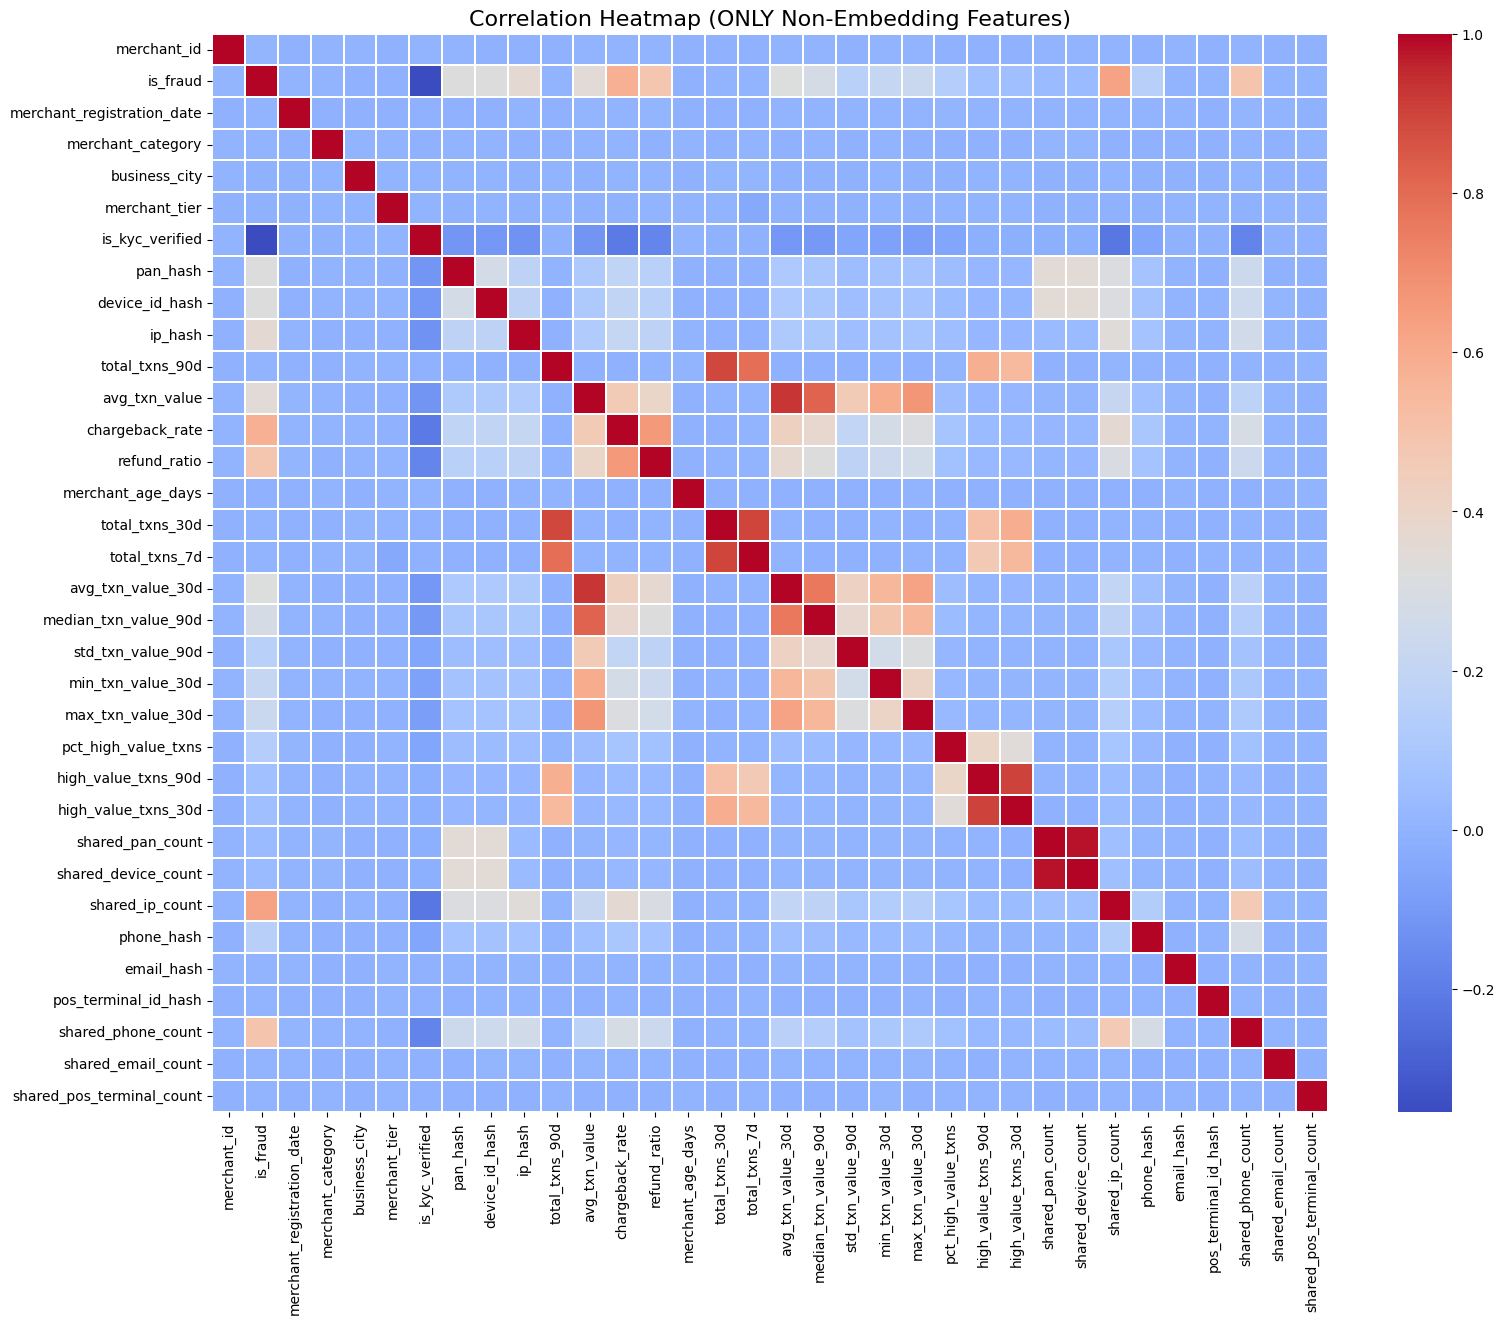

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# ----------------------------------------------------------
# LOAD DATA
# ----------------------------------------------------------
df = pd.read_csv("merchant_synthetic_100k_phase6.csv")

# ----------------------------------------------------------
# REMOVE EMBEDDING COLUMNS
# ----------------------------------------------------------
non_embed_df = df[[c for c in df.columns if not c.startswith("emb_")]]

print("Non-embedding features:", len(non_embed_df.columns))
print(non_embed_df.columns.tolist())

# ----------------------------------------------------------
# ENCODE CATEGORICAL COLUMNS
# ----------------------------------------------------------
label_cols = non_embed_df.select_dtypes(include=["object"]).columns

le = LabelEncoder()
for col in label_cols:
    non_embed_df[col] = le.fit_transform(non_embed_df[col].astype(str))

# ----------------------------------------------------------
# CALCULATE CORRELATION
# ----------------------------------------------------------
corr = non_embed_df.corr()

# ----------------------------------------------------------
# PLOT HEATMAP
# ----------------------------------------------------------
plt.figure(figsize=(18, 14))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=False,
    linewidths=0.3
)
plt.title("Correlation Heatmap (ONLY Non-Embedding Features)", fontsize=16)
plt.show()


In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# ===============================
# Load dataset
# ===============================
df = pd.read_csv("merchant_synthetic_100k_phase6.csv")

print("Original shape:", df.shape)

# ===============================
# Remove unwanted columns
# ===============================

cols_to_remove = [
    "merchant_registration_date",
    "merchant_age_days",
    "pan_hash",
    "device_id_hash",
    "ip_hash",
    "phone_hash",
    "pos_terminal_id_hash",
    "email_hash",
    "business_city"    # <-- removed as requested
]

df = df.drop(columns=cols_to_remove)
print("After removing columns:", df.shape)

# ===============================
# Prepare X and y
# ===============================

y = df["is_fraud"]
X = df.drop(columns=["is_fraud", "merchant_id"])  # remove target + merchant_id

# ===============================
# Encode ONLY 2 categorical features:
#   - merchant_tier
#   - merchant_category
# ===============================

categorical_cols = ["merchant_tier", "merchant_category"]

print("Encoding categorical columns:", categorical_cols)

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

print("Final X matrix shape:", X.shape)
print("Final feature list:")
print(list(X.columns))


Original shape: (100000, 50)
After removing columns: (100000, 41)
Encoding categorical columns: ['merchant_tier', 'merchant_category']
Final X matrix shape: (100000, 39)
Final feature list:
['merchant_category', 'merchant_tier', 'is_kyc_verified', 'total_txns_90d', 'avg_txn_value', 'chargeback_rate', 'refund_ratio', 'total_txns_30d', 'total_txns_7d', 'avg_txn_value_30d', 'median_txn_value_90d', 'std_txn_value_90d', 'min_txn_value_30d', 'max_txn_value_30d', 'pct_high_value_txns', 'high_value_txns_90d', 'high_value_txns_30d', 'shared_pan_count', 'shared_device_count', 'shared_ip_count', 'shared_phone_count', 'shared_email_count', 'shared_pos_terminal_count', 'emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6', 'emb_7', 'emb_8', 'emb_9', 'emb_10', 'emb_11', 'emb_12', 'emb_13', 'emb_14', 'emb_15']


Train shape: (75000, 39)
Test shape: (25000, 39)
Scale_pos_weight: 8.090909090909092

Training XGBoost...

ACCURACY: 0.98632

CONFUSION MATRIX:
[[22065   185]
 [  157  2593]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     22250
           1       0.93      0.94      0.94      2750

    accuracy                           0.99     25000
   macro avg       0.96      0.97      0.97     25000
weighted avg       0.99      0.99      0.99     25000



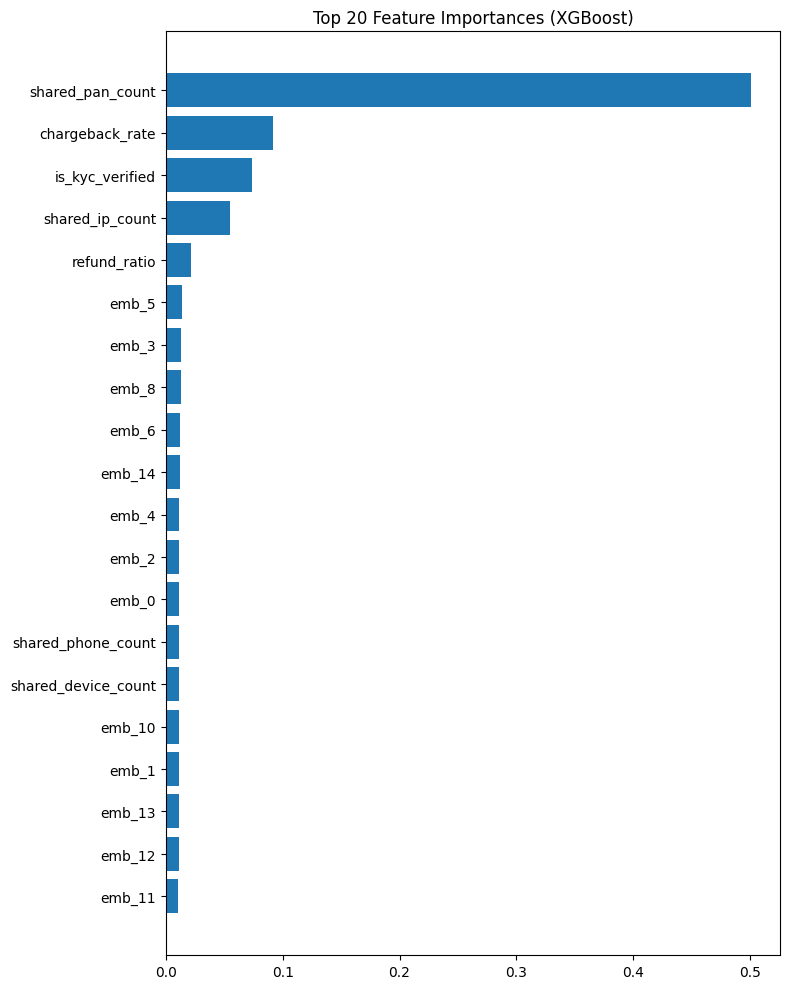

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Class imbalance ratio
fraud_ratio = y.mean()
scale_pos_weight = (1 - fraud_ratio) / fraud_ratio
print("Scale_pos_weight:", scale_pos_weight)

# =====================================================
# XGBOOST MODEL
# =====================================================
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.07,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    tree_method="hist",
    scale_pos_weight=scale_pos_weight
)

print("\nTraining XGBoost...")
model.fit(X_train, y_train)

# =====================================================
# EVALUATE
# =====================================================
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nACCURACY:", accuracy_score(y_test, y_pred))
print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred))

print("\nCLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
# =====================================================
# FEATURE IMPORTANCE PLOT
# =====================================================
importance = model.feature_importances_
feat_names = X.columns

sorted_idx = importance.argsort()[-20:]  # Top 20 features

plt.figure(figsize=(8, 10))
plt.barh(feat_names[sorted_idx], importance[sorted_idx])
plt.title("Top 20 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from community import community_louvain

# =====================================================
# LOAD DATA
# =====================================================
print("Loading merchant data and edges...")
df = pd.read_csv("merchant_synthetic_100k_phase6.csv")
edges = pd.read_csv("merchant_edges.csv")

print(f"Total merchants: {len(df)}")
print(f"Total edges: {len(edges)}")

# =====================================================
# FILTER ONLY FRAUD MERCHANTS
# =====================================================
fraud_merchants = set(df[df["is_fraud"] == 1]["merchant_id"].tolist())
print(f"Fraud merchants: {len(fraud_merchants)}")

# Filter edges to only include fraud merchants
fraud_edges = edges[
    (edges["merchant_A"].isin(fraud_merchants)) & 
    (edges["merchant_B"].isin(fraud_merchants))
].copy()

print(f"Edges between fraud merchants: {len(fraud_edges)}")

# =====================================================
# BUILD FRAUD NETWORK GRAPH
# =====================================================
print("\nBuilding fraud network graph...")

G = nx.Graph()
G.add_nodes_from(fraud_merchants)

# Add weighted edges
for _, row in fraud_edges.iterrows():
    G.add_edge(
        row["merchant_A"], 
        row["merchant_B"], 
        weight=row["weight"],
        reason=row["reason"]
    )

print(f"Graph nodes: {G.number_of_nodes()}")
print(f"Graph edges: {G.number_of_edges()}")

# =====================================================
# LOUVAIN COMMUNITY DETECTION
# =====================================================
print("\nDetecting communities using Louvain algorithm...")

partition = community_louvain.best_partition(G, weight="weight")
nx.set_node_attributes(G, partition, "community")

print(f"Communities detected: {len(set(partition.values()))}")

# =====================================================
# EXTRACT LARGEST COMMUNITY
# =====================================================
from collections import Counter

comm_counts = Counter(partition.values())
largest_comm = comm_counts.most_common(1)[0][0]
comm_size = comm_counts.most_common(1)[0][1]

print(f"\nLargest community ID: {largest_comm}")
print(f"Largest community size: {comm_size} merchants")

sub_nodes = [n for n, c in partition.items() if c == largest_comm]
H = G.subgraph(sub_nodes).copy()

print(f"Subgraph: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")

# =====================================================
# CALCULATE NODE POSITIONS
# =====================================================
print("\nCalculating node positions (spring layout)...")

pos = nx.spring_layout(H, seed=42, weight="weight", iterations=50, k=0.5)

# Extract coordinates
x_nodes = [pos[n][0] for n in H.nodes()]
y_nodes = [pos[n][1] for n in H.nodes()]

# =====================================================
# CREATE EDGE TRACE
# =====================================================
edge_x, edge_y = [], []
for edge in H.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    mode="lines",
    hoverinfo="none",
    line=dict(width=0.5, color="#888888"),
    name="Edges"
)

# =====================================================
# CREATE NODE TRACE
# =====================================================
node_trace = go.Scatter(
    x=x_nodes,
    y=y_nodes,
    mode="markers",
    hoverinfo="text",
    marker=dict(
        showscale=True,
        colorscale="Turbo",
        color=[partition[n] for n in H.nodes()],
        size=10,
        line=dict(width=1, color="white"),
        colorbar=dict(
            title=dict(text="Community ID"),
            thickness=15,
            len=0.7
        )
    ),
    text=[f"Merchant: {n}<br>Community: {partition[n]}" for n in H.nodes()],
    name="Merchants"
)

# =====================================================
# CREATE FIGURE WITH PLOTLY
# =====================================================
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title=dict(
            text=f"Fraud Network Visualization (Largest Community - {comm_size} merchants)",
            font=dict(size=22, color="#2c3e50"),
            x=0.5,
            xanchor="center"
        ),
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=5, r=5, t=80),
        plot_bgcolor="rgba(240, 240, 240, 0.9)",
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        width=1200,
        height=800
    )
)

fig.show()

# =====================================================
# PRINT COMMUNITY STATISTICS
# =====================================================
print("\n" + "="*60)
print("COMMUNITY STATISTICS")
print("="*60)

all_communities = sorted(set(partition.values()))
for comm_id in all_communities[:10]:  # Top 10 communities
    comm_merchants = [n for n, c in partition.items() if c == comm_id]
    comm_edges = H.subgraph(comm_merchants).number_of_edges() if len(comm_merchants) > 1 else 0
    print(f"Community {comm_id}: {len(comm_merchants)} merchants, {comm_edges} edges")

# =====================================================
# SAVE COMMUNITY DATA
# =====================================================
print("\n" + "="*60)
print("Saving community analysis...")
print("="*60)

# Save all communities
community_data = []
for merchant_id, comm_id in partition.items():
    community_data.append({
        'merchant_id': merchant_id,
        'community_id': comm_id
    })

comm_df = pd.DataFrame(community_data)
comm_df.to_csv("merchant_communities.csv", index=False)
print("✓ Saved: merchant_communities.csv")

# Save largest community details
largest_comm_df = pd.DataFrame({'merchant_id': sub_nodes})
largest_comm_df = largest_comm_df.merge(
    df[['merchant_id', 'merchant_tier', 'merchant_category', 'is_kyc_verified', 'avg_txn_value', 'chargeback_rate']],
    on='merchant_id'
)
largest_comm_df.to_csv("largest_fraud_community_merchants.csv", index=False)
print("✓ Saved: largest_fraud_community_merchants.csv")

print("\n✓ FRAUD NETWORK VISUALIZATION COMPLETE")

Loading merchant data and edges...
Total merchants: 100000
Total edges: 11015
Fraud merchants: 11000
Edges between fraud merchants: 11015

Building fraud network graph...
Graph nodes: 11000
Graph edges: 11015

Detecting communities using Louvain algorithm...
Communities detected: 1083

Largest community ID: 307
Largest community size: 43 merchants
Subgraph: 43 nodes, 58 edges

Calculating node positions (spring layout)...



COMMUNITY STATISTICS
Community 0: 9 merchants, 0 edges
Community 1: 8 merchants, 0 edges
Community 2: 14 merchants, 0 edges
Community 3: 8 merchants, 0 edges
Community 4: 8 merchants, 0 edges
Community 5: 15 merchants, 0 edges
Community 6: 7 merchants, 0 edges
Community 7: 8 merchants, 0 edges
Community 8: 9 merchants, 0 edges
Community 9: 9 merchants, 0 edges

Saving community analysis...
✓ Saved: merchant_communities.csv
✓ Saved: largest_fraud_community_merchants.csv

✓ FRAUD NETWORK VISUALIZATION COMPLETE
